In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
sns.set_style('ticks')
import xlrd
import datetime

In [2]:
import curveball

## Data

,Row,Col,Color,Strain
0,A,1,#4daf4a,DH5a
1,A,2,#4daf4a,DH5a
2,A,3,#4daf4a,DH5a
3,A,4,#4daf4a,DH5a
4,A,5,#377eb8,Competition


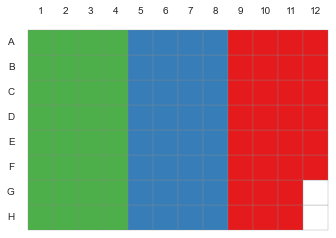

In [3]:
plate = pd.read_csv('../plate_templates/DH5a-TG1.csv')
curveball.plots.plot_plate(plate)
plate.head()

In [4]:
datadir = os.path.join('d:\\', 'dropbox', 'ex silico', 'tecan')
file_pattern = 'Yoav_260515_competition.xlsx'

filename = os.path.join(datadir, file_pattern)
print filename, os.path.exists(filename)

d:\dropbox\ex silico\tecan\Yoav_260515_competition.xlsx True


In [5]:
df = curveball.ioutils.read_tecan_xlsx(filename, label='OD', plate=plate)
print df.shape
df.head()

(2304, 9)


,Time,Temp. [°C],Cycle Nr.,Well,OD,Row,Col,Color,Strain
0,2.075000,30.1,1,A1,0.3889,A,1,#4daf4a,DH5a
1,2.307417,29.9,2,A1,0.4125,A,1,#4daf4a,DH5a
2,2.539833,29.9,3,A1,0.4325,A,1,#4daf4a,DH5a
3,2.773083,30.2,4,A1,0.4477,A,1,#4daf4a,DH5a
4,1.002778,29.9,1,A1,0.3051,A,1,#4daf4a,DH5a


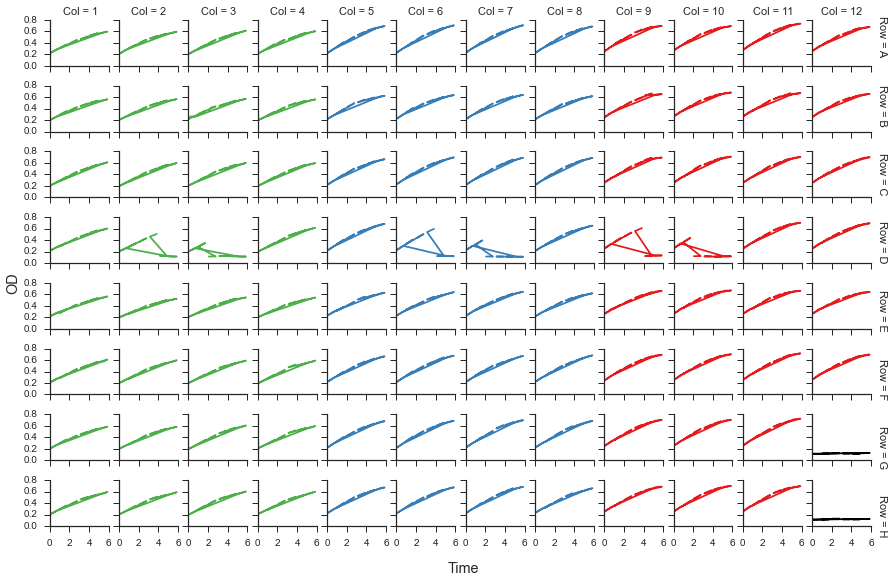

In [6]:
curveball.plots.plot_wells(df)

Some wells shouldn't be used as we extracted their contents for the microscope images.

In [7]:
df = df[~df.Well.isin(['D2','D3','D6','D7','D9','D10'])]

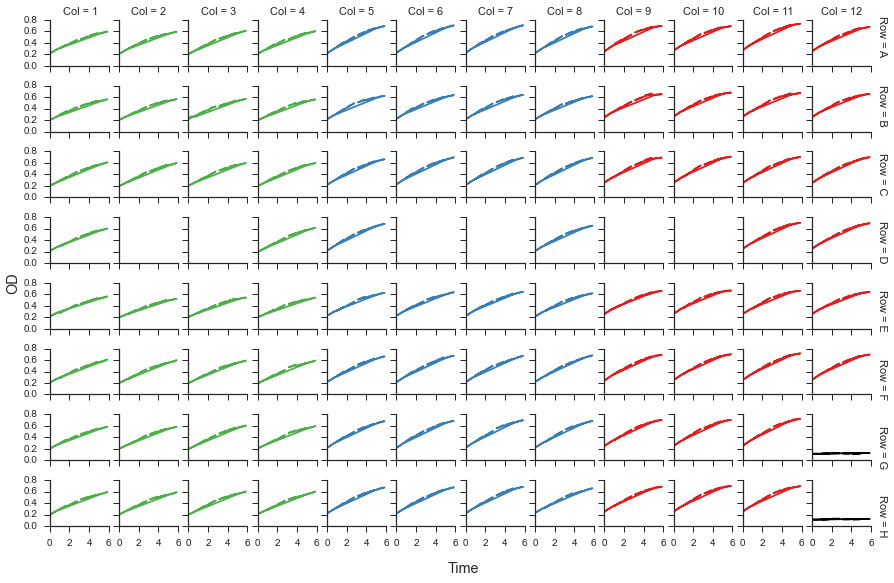

In [8]:
curveball.plots.plot_wells(df)

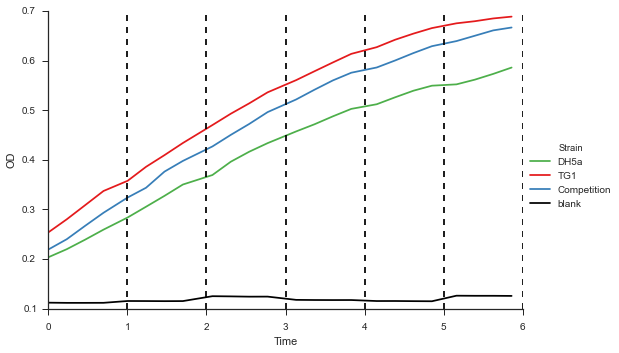

In [9]:
g = curveball.plots.plot_strains(df, by=('Strain', 'Time'))
for i in range(7):
    g.axes[0,0].axvline(x=i, color='k', ls='--')

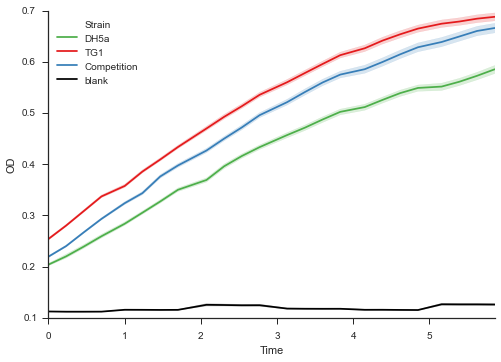

In [10]:
curveball.plots.tsplot(df)

## Models

[[Model]]
    Model(logistic_function)
[[Fit Statistics]]
    # function evals   = 23
    # data points      = 24
    # variables        = 3
    chi-square         = 2.505
    reduced chi-square = 0.119
[[Variables]]
    y0:   0.25867316 +/- 0.001329 (0.51%) (init= 0.2539714)
    r:    0.57507799 +/- 0.009714 (1.69%) (init= 0.3999762)
    K:    0.73551689 +/- 0.005718 (0.78%) (init= 0.6884643)



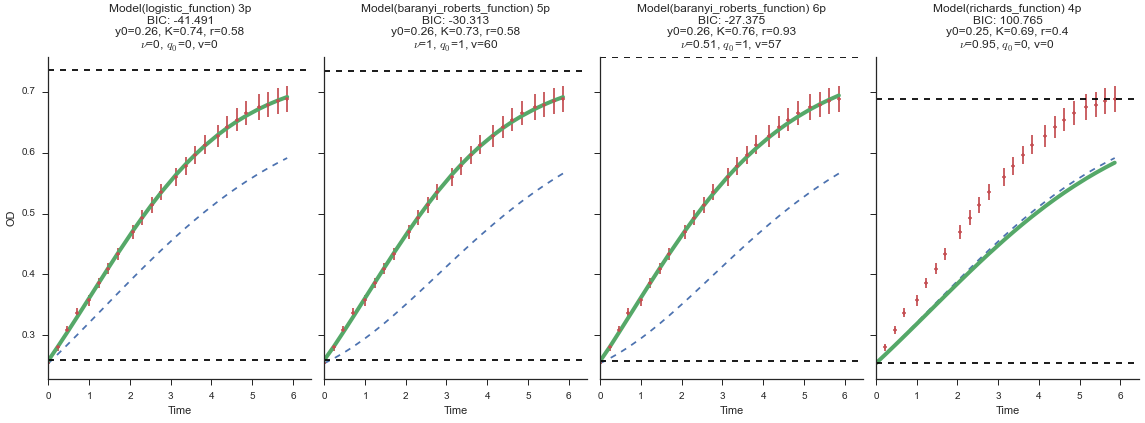

In [11]:
TG1_model = curveball.models.fit_model(df[df.Strain=='TG1'])[0][0]

[[Model]]
    Model(logistic_function)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 24
    # variables        = 3
    chi-square         = 1.170
    reduced chi-square = 0.056
[[Variables]]
    y0:   0.20334580 +/- 0.001100 (0.54%) (init= 0.20386)
    r:    0.55478223 +/- 0.008199 (1.48%) (init= 0.3145875)
    K:    0.62370440 +/- 0.004476 (0.72%) (init= 0.5859033)



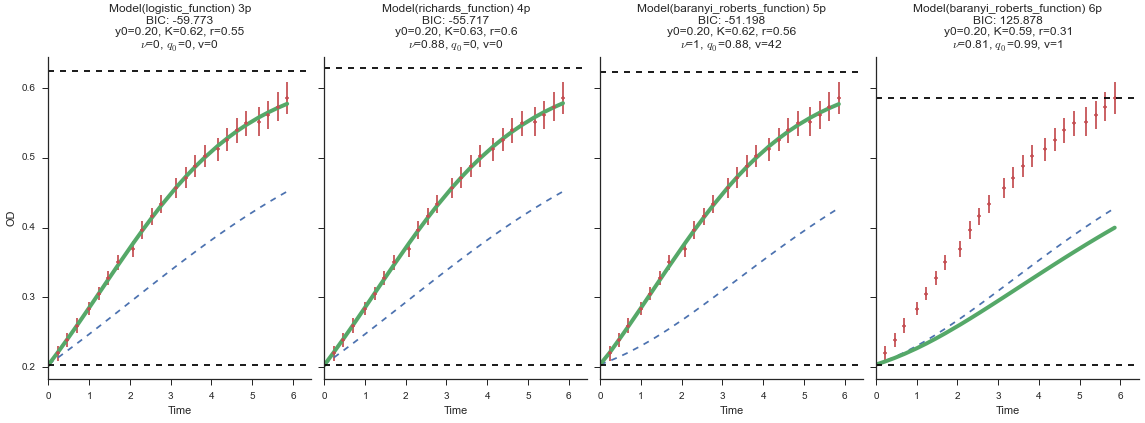

In [12]:
DH5a_model = curveball.models.fit_model(df[df.Strain=='DH5a'])[0][0]

In [13]:
curveball.models.find_all_outliers(df[df.Strain=='TG1'], TG1_model, max_outlier_fraction=0.5)

[[u'A11'], [u'A10', u'F9']]

In [14]:
curveball.models.find_all_outliers(df[df.Strain=='DH5a'], DH5a_model, max_outlier_fraction=0.5)

[[u'E2'], [u'E4'], [u'A4', u'E3'], [u'A1', u'A2'], [u'A3'], [u'B4', u'E1']]

In [15]:
TG1_color = df[df.Strain=='TG1'].Color.unique()[0]
DH5a_color = df[df.Strain=='DH5a'].Color.unique()[0]

## Flow cytometry

In [ ]:
flow = pd.read_csv('D:/Google Drive/ex silico/flow/competition/2015-05-19/flow_analysis.csv')
red,blue,green = sns.color_palette('Set1', 3)
sns.tsplot(flow, 'Time', 'Col', 'Well', 'RedPercent', color={'Red':red,'Green':green,'Both':blue}, estimator=np.nanmean)
sns.despine()

In [ ]:
flow_agg = flow[flow.Well=='Both'].groupby('Time').RedPercent.agg([np.mean, np.std]).reset_index()
flow_agg.head()

In [ ]:
plt.errorbar(flow_agg.Time, flow_agg['mean'], flow_agg['std'], fmt='o', color=TG1_color)
plt.xlabel('Time (hour)')
plt.ylabel('TG1 frequency')
sns.despine()

In [ ]:
p0 = flow_agg['mean'][0]
print 'p0', p0
min_OD = df[df.Strain=='Competition'].OD.min()
y0 = min_OD*p0, min_OD*(1-p0)
print 'y0', y0

## Competition

In [16]:
y0 = TG1_model.best_values['y0']/2, DH5a_model.best_values['y0']/2

In [19]:
reload(curveball.competitions)

<module 'curveball.competitions' from 'd:\workspace\curveball_project\python\curveball\competitions.py'>

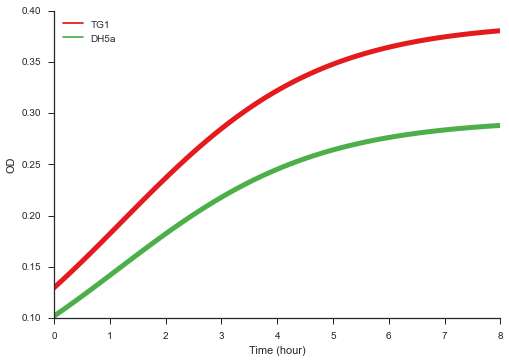

In [20]:
t,y,fig,ax = curveball.competitions.compete(TG1_model, DH5a_model, y0=y0, hours=8, 
                                            colors=[TG1_color, DH5a_color], PLOT=True)
ax.get_lines()[0].set_color(TG1_color)
ax.get_lines()[1].set_color(DH5a_color)
ax.legend(['TG1', 'DH5a'], loc='upper left');

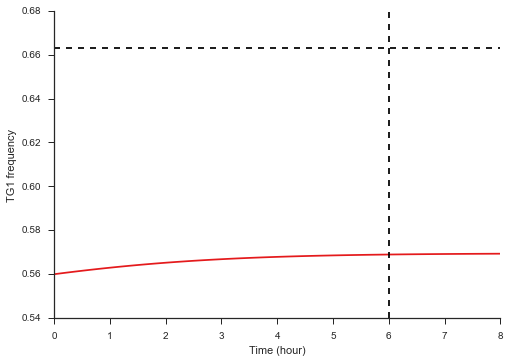

In [21]:
p = y[:,0] / y.sum(axis=1)
plt.plot(t, p, color=TG1_color)
plt.axvline(x=6, color='k', ls='--')
plt.axhline(y=0.663, color='k', ls='--')
plt.xlabel('Time (hour)')
plt.ylabel('TG1 frequency')
sns.despine()

In [22]:
df_compete = df[df.Strain=='Competition'].groupby(['Time']).OD.agg([np.mean, np.std]).reset_index()
df_compete.head()

,Time,mean,std
0,0.000000,0.219423,0.005179
1,0.232500,0.240130,0.005521
2,0.465000,0.267117,0.005586
3,0.697500,0.293427,0.006314
4,1.002778,0.324140,0.008166


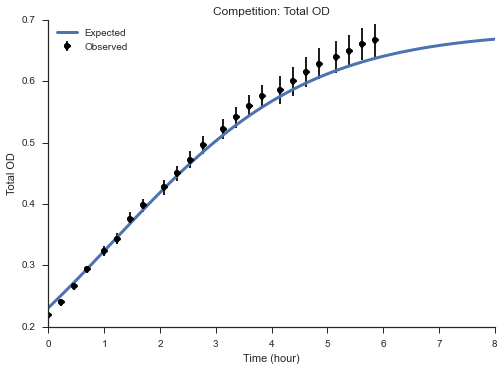

In [23]:
plt.plot(t, y.sum(axis=1), lw=3, label='Expected')
plt.errorbar(df_compete.Time, df_compete['mean'], df_compete['std'], fmt='ok', label='Observed')
#plt.fill_between(df_compete.Time, df_compete['mean'] + df_compete['std'], df_compete['mean'] - df_compete['std'], 
#                 color='gray', alpha=0.5)
plt.xlabel('Time (hour)')
plt.ylabel('Total OD')
plt.legend(loc='upper left')
plt.title('Competition: Total OD')
sns.despine()